# Image generation

In Part 1 of this course, we focused mainly on models that were useful for classification. However, many applications require generating much higher dimensional results, such as images and sentences. Examples include:
* Text: neural translation, text to speech, image captioning
* Image: Segmentation, artistic filters, image sharpening and cleaning

In [1]:
%matplotlib inline
import importlib
import imageio
import utils2_exp; importlib.reload(utils2_exp)
from utils2_exp import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

import vgg16_avg_exp; importlib.reload(vgg16_avg_exp)

from vgg16_avg_exp import VGG16_Avg

Using TensorFlow backend.


In [2]:
# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()

Data can be downloaded from [here](http://files.fast.ai/data/imagenet-sample-train.tar.gz). Update path below to where you download data to. Optionally use a 2nd path for fast (e.g. SSD) storage - set both to the same path if using AWS.

In [3]:
ls /opt/notebooks/data/fastai/

VanGogh-starry_night.jpg    VanGogh-starry_night.jpg.5
VanGogh-starry_night.jpg.1  VanGogh-starry_night.jpg.6
VanGogh-starry_night.jpg.2  imagenet-sample-train/
VanGogh-starry_night.jpg.3  imagenet-sample-train.tar.gz
VanGogh-starry_night.jpg.4


In [4]:
!wget https://upload.wikimedia.org/wikipedia/commons/c/cd/VanGogh-starry_night.jpg -P /opt/notebooks/data/fastai

--2017-12-15 16:09:20--  https://upload.wikimedia.org/wikipedia/commons/c/cd/VanGogh-starry_night.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 780240 (762K) [image/jpeg]
Saving to: '/opt/notebooks/data/fastai/VanGogh-starry_night.jpg.7'

VanGogh-starry_nigh 100%[===================>] 761.95K  4.38MB/s    in 0.2s    

2017-12-15 16:09:21 (4.38 MB/s) - '/opt/notebooks/data/fastai/VanGogh-starry_night.jpg.7' saved [780240/780240]



In [5]:
# path = '/data/datasets/imagenet/sample/'
# dpath = '/data/jhoward/fast/imagenet/sample/'
path = '/opt/notebooks/data/fastai/imagenet-sample-train/train/'

## Neural style transfer

The first use case of an image to image architecture we're going to look at is neural style transfer, using the approach in [this paper](https://arxiv.org/abs/1508.06576). This is a fairly popular application of deep learning in which an image is recreated in the style of a work of art, such as Van Gogh's Starry Night. For more information about the use of neural networks in art, see this [Scientific American article](https://blogs.scientificamerican.com/sa-visual/neural-networks-for-artists/) or [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta).

### Setup

Our first step is to list out the files we have, and then grab some image.

In [6]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
fnames = fnames
n = len(fnames); n

19439

In [7]:
fn = np.random.choice(fnames); fn

'/opt/notebooks/data/fastai/imagenet-sample-train/train/n01806143/n01806143_225.JPEG'

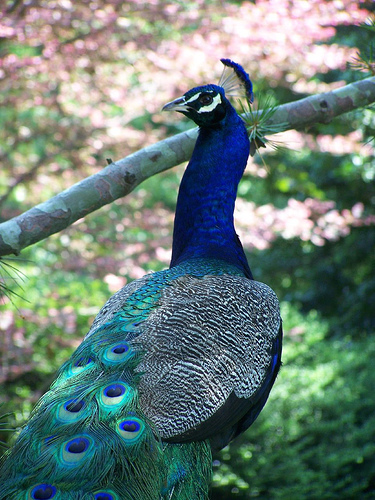

In [8]:
img=Image.open(fn); img

That's a nice looking image! Feel free to use any other image that you're interested in playing with.

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [9]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [10]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [11]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [12]:
shp

(1, 500, 375, 3)

#### Broadcasting examples

In [13]:
np.array([1,2,3]) - 2

array([-1,  0,  1])

In [14]:
np.array([2,3]).reshape(1,1,1,2)

array([[[[2, 3]]]])

In [15]:
np.array([2,3]).reshape(1,1,2,1)

array([[[[2],
         [3]]]])

In [16]:
a = np.random.randn(5,1,3,2)
b = np.random.randn(2)
(a-b).shape

(5, 1, 3, 2)

### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layes, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.

The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [17]:
model = VGG16_Avg(include_top=False)

Here we're grabbing the activations from near the end of the convolutional model).

In [18]:
layer = model.get_layer('block5_conv1').output

And let's calculate the target activations for this layer:

In [19]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require.

In [20]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

In [21]:
loss = K.mean(K.square(layer - targ), axis=None)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_l_bfgs_b` funtionc. 

In [22]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val) 
        imageio.imwrite(f'{path}results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

Next we need to generate a random image.

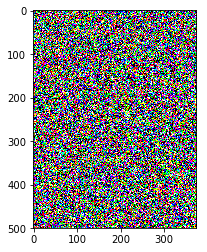

In [29]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [30]:
iterations=100

In [31]:
x = solve_image(evaluator, iterations, x)

Current loss value: 148.631973267


/opt/conda/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 250.68000030517578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Current loss value: 123.067428589
Current loss value: 106.679367065
Current loss value: 93.8038635254
Current loss value: 82.5205688477
Current loss value: 73.3418502808
Current loss value: 67.0033721924
Current loss value: 64.3490905762
Current loss value: 57.7090110779
Current loss value: 55.219745636
Current loss value: 52.8887290955
Current loss value: 49.1106414795
Current loss value: 47.082950592
Current loss value: 45.1697311401
Current loss value: 40.2076835632
Current loss value: 37.3721313477
Current loss value: 36.2382774353
Current loss value: 34.7723808289
Current loss value: 33.678237915
Current loss value: 30.6061782837
Current loss value: 29.8026714325
Current loss value: 28.2620658875
Current loss value: 27.3027496338
Current loss value: 25.0258541107
Current loss value: 24.0131912231
Current loss value: 23.3620872498
Current loss value: 21.7072525024
Current loss value: 21.3151931763
Current loss value: 20.9221973419
Current loss value: 20.5703468323
Current loss valu

Our result by comparing output at conv 1 of last block (5) is fairly amorphous, but still easily recognizable as a bird. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing, such as an eye or a beak.

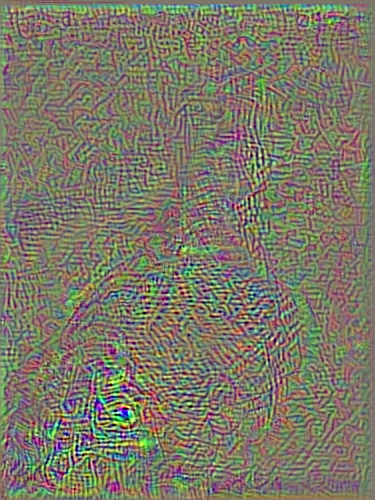

In [32]:
Image.open(path + 'results/res_at_iteration_0.png')

If instead we optimized by calculating loss from the output of conv 1 of 4th block, our trained image looks much more like the original. This makes sense because with less transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

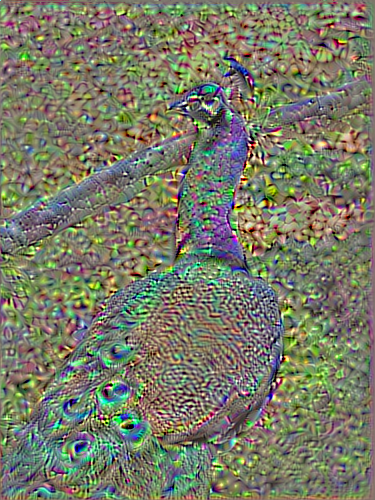

In [33]:
Image.open(path + 'results/res_at_iteration_99.png')

### Recreate style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By "style", we mean the color palette and texture of an image. Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

Here are some examples of images we can extract style from.

In [34]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [35]:
ls /opt/notebooks/data/fastai/

VanGogh-starry_night.jpg    VanGogh-starry_night.jpg.5
VanGogh-starry_night.jpg.1  VanGogh-starry_night.jpg.6
VanGogh-starry_night.jpg.2  VanGogh-starry_night.jpg.7
VanGogh-starry_night.jpg.3  imagenet-sample-train/
VanGogh-starry_night.jpg.4  imagenet-sample-train.tar.gz


In [38]:
shp[1:3][::-1]

(375, 500)

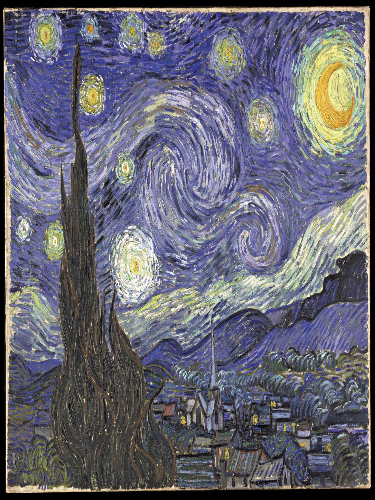

In [39]:
style = Image.open('/opt/notebooks/data/fastai/VanGogh-starry_night.jpg')
# style = style.resize(np.divide(style.size,3.5).astype('int32')); style
style = style.resize(shp[1:3][::-1]); style

We're going to repeat the same approach as before, but with some differences.

In [40]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [41]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500, 375, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 375, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 375, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 250, 187, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 187, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 187, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 125, 93, 128)      0         
__________

One thing to notice is that we're actually going to be calculating the loss function multiple layers, rather than just one. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

In [43]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [44]:
layers

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(?, 500, 375, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(?, 250, 187, 128) dtype=float32>]

In [45]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [46]:
layers_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500, 375, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 375, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 375, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 250, 187, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 187, 128)     73856     
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________


In [47]:
style_arr.shape

(1, 500, 375, 3)

In [48]:
targ.shape

TensorShape([Dimension(1), Dimension(31), Dimension(23), Dimension(512)])

The key difference is our choice of loss function. Whereas before we were calculating mse of the raw convolutional outputs, here we transform them into the "gramian matrix" of their channels (that is, the product of a matrix and its transpose) before taking their mse. It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [49]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [50]:
def style_loss(x, targ): return K.mean(K.square(gram_matrix(x) - gram_matrix(targ)), axis=None)

In [51]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We then solve as we did before.

In [52]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

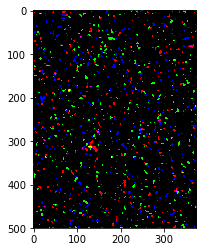

In [53]:
plt.imshow(x[0]);

In [55]:
iterations=100
x = rand_img(shp)

In [57]:
x = solve_image(evaluator, iterations, x)

Current loss value: 88.4171981812


/opt/conda/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 250.68000030517578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Current loss value: 86.4293289185
Current loss value: 86.1435012817
Current loss value: 85.8813552856
Current loss value: 83.8658370972
Current loss value: 83.5901031494
Current loss value: 81.6556091309
Current loss value: 81.4945831299
Current loss value: 80.9810333252
Current loss value: 80.7959136963
Current loss value: 77.4771652222
Current loss value: 76.9906921387
Current loss value: 76.4141387939
Current loss value: 69.5383148193
Current loss value: 67.0373458862
Current loss value: 66.6145172119
Current loss value: 65.979598999
Current loss value: 65.4891891479
Current loss value: 65.0122070312
Current loss value: 63.6251144409
Current loss value: 63.3432388306
Current loss value: 63.2153625488
Current loss value: 62.8624038696
Current loss value: 56.0128593445
Current loss value: 55.2961425781
Current loss value: 55.2031784058
Current loss value: 53.9635009766
Current loss value: 53.2724189758
Current loss value: 53.014339447
Current loss value: 52.915184021
Current loss valu

Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning.

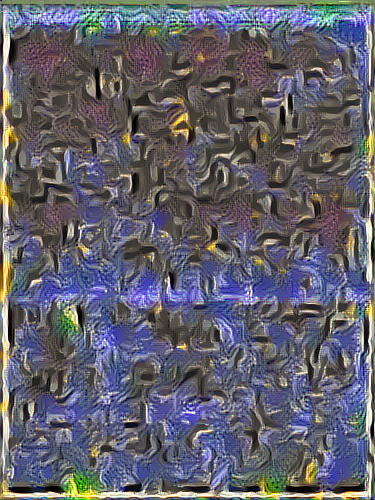

In [58]:
Image.open(path + 'results/res_at_iteration_99.png')

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

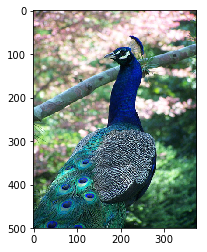

In [59]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [60]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [61]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [62]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [63]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [64]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += K.mean(metrics.mse(content_layer, content_targ)/10, axis=None)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [65]:
evaluator = Evaluator(transfer_fn, shp)

In [68]:
iterations=200
x = rand_img(shp)

In [69]:
x = solve_image(evaluator, iterations, x)

Current loss value: 19075.03125


/opt/conda/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 250.68000030517578]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


Current loss value: 16695.5839844
Current loss value: 14595.6162109
Current loss value: 12765.7324219
Current loss value: 11169.5888672
Current loss value: 9751.06640625
Current loss value: 8486.30273438
Current loss value: 7352.21289062
Current loss value: 6348.54589844
Current loss value: 5471.88476562
Current loss value: 4709.88232422
Current loss value: 4061.22802734
Current loss value: 3517.25024414
Current loss value: 3068.05175781
Current loss value: 2700.51416016
Current loss value: 2428.3840332
Current loss value: 2146.07739258
Current loss value: 2124.23681641
Current loss value: 1964.57299805
Current loss value: 1918.21142578
Current loss value: 1871.29431152
Current loss value: 1826.9576416
Current loss value: 1784.03955078
Current loss value: 1744.27050781
Current loss value: 1733.65917969
Current loss value: 1691.94360352
Current loss value: 1654.35961914
Current loss value: 1644.61560059
Current loss value: 1509.06616211
Current loss value: 1466.97973633
Current loss val

These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

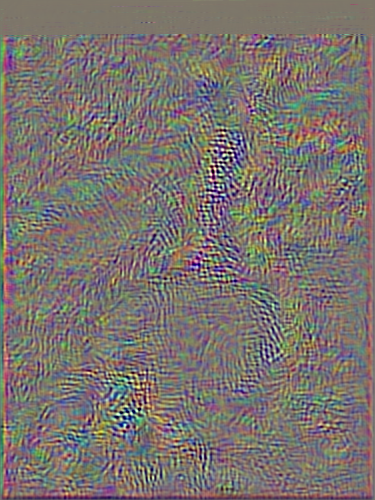

In [70]:
Image.open(path + 'results/res_at_iteration_1.png')

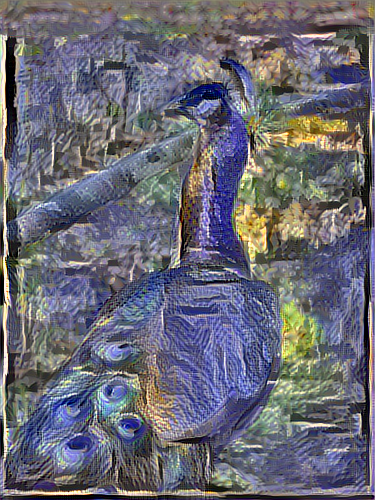

In [73]:
Image.open(path + 'results/res_at_iteration_199.png')

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .